In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gamma, norm
from scipy.optimize import minimize_scalar

sns.set(style="whitegrid")
colors = sns.color_palette("Paired")

%load_ext lab_black

# 4. Laplace's Method Demo*

## Steps

As we learned in the last lecture, these are the steps to Laplace approximation:

1. **Find the mode**.

The mean of the approximating normal distribution will be the mode, or maximum a posteriori probability (MAP) solution, of the posterior.

We solve for the MAP by maximizing the unnormalized posterior with respect to $\theta$ or by maximizing the log of the unnormalized posterior:

$$\hat{\theta} = \arg\max_\theta \log(g(\theta))=\arg\max_\theta\log(f(x|\theta)\pi(\theta))$$

2. **Find the variance**.

In the lecture notation:

$$Q = - \left[ \frac{\partial^2 \log(g(\theta))}{\partial \theta^2}\right]_{\theta=\hat{\theta}}$$

3. **Normal approximation**: 

The Laplace approximation to the posterior is a normal distribution with mean $\hat{\theta}$ and variance $Q^{-1}$:

$$g(\theta|x) \approx N(\hat{\theta},Q^{-1})$$

## Univariate example

From [Unit 5: laplace.m](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit5/laplace.m).

Here's our example model:

$$
\begin{align*}
x|\theta & \sim Ga(r, \theta) \\
\theta & \sim Ga(\alpha, \beta)
\end{align*}
$$

Since this is a conjugate model, we already know the exact posterior is $Ga(r+\alpha - 1, \beta +x)$. We know the mode is $\frac{r + \alpha - 1}{\beta + x}$, but let's pretend we don't.

\begin{align*}
f(x|\theta)\pi(\theta) &\propto x^{r-1}e^{-\theta x}\theta^{\alpha-1}e^{-\beta \theta} \\
 &\propto \theta^{r + \alpha -1}e^{-(\beta + x)\theta}
\end{align*}

### Mode
In this case it's not too tough to find the mode analytically.

The log of the unnormalized posterior is $\log g(\theta) = (r + \alpha - 1)\log(\theta) - (\beta + x)\theta$, so we can just take the derivative and set it equal to zero, then solve for $\theta$:

$$
\begin{align*}
\frac{d}{d\theta} \log g(\theta) &= \frac{d}{d\theta} \left[(r + \alpha - 1)\log(\theta) - (\beta + x)\theta\right] \\
&= \frac{r + \alpha - 1}{\theta} - (\beta + x) \\
0 &= \frac{r + \alpha - 1}{\theta} - (\beta + x) \\
\beta + x &= \frac{r + \alpha - 1}{\theta} \\
\theta &= \frac{r + \alpha - 1}{\beta + x}
\end{align*}
$$

For this example our given parameters are $r=20, \alpha=5, \beta=1, x=2$, so our mode is equal to $8$.

We could also use optimization:

In [2]:
# define our posterior
def neg_log_post(θ, r, α, β, x):
    return -((r + α - 1) * np.log(θ) - (β + x) * θ)


r, α, β, x = 20, 5, 1, 2

result = minimize_scalar(
    neg_log_post, bounds=(0, 1e6), args=(r, α, β, x), method="bounded"
)

mode = result.x

print(f"Mode: {mode}")

Mode: 8.000001689177818


### Variance

The true variance of the posterior is $\frac{r+\alpha - 1}{(\beta + x)^2}$.

The approximation distribution's variance will be: 

$$Q^{-1} = - \left[ \frac{\partial^2 \log g(\theta)}{\partial\theta^2}\right]^{-1}_{\theta=\hat{\theta}} = \left(\frac{\alpha + r -1}{{\hat\theta}^2}\right)^{-1}$$

$$$$

### Compare the true posterior with the approximation

In [3]:
xx = np.linspace(0, 16, 100000)

variance = (mode**2) / (α + r - 1)

# normal parameters
mu = mode
sigma = variance**0.5

# gamma parameters
shape = r + α
scale = 1 / (β + x)

exact = gamma.pdf(xx, a=shape, scale=scale)
approx = norm.pdf(xx, mu, sigma)

# credible intervals
exact_ci = gamma.ppf(0.025, a=shape, scale=scale), gamma.ppf(
    0.975, a=shape, scale=scale
)
approx_ci = norm.ppf(0.025, mu, sigma), norm.ppf(0.975, mu, sigma)

print(f"Exact 95% credible interval: {exact_ci}")
print(f"Laplace approximation 95% credible interval: {approx_ci}")

Exact 95% credible interval: (5.392893949276442, 11.903365864584403)
Laplace approximation 95% credible interval: (4.799393229141485, 11.20061014921415)


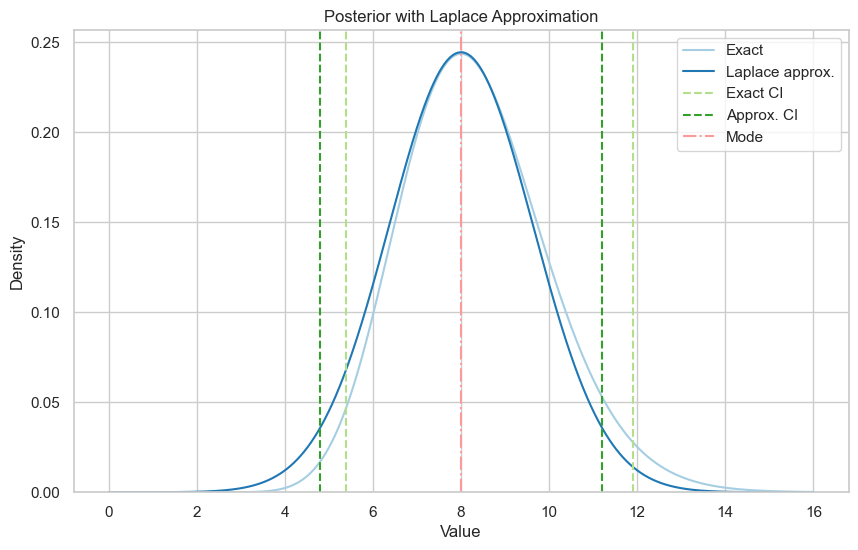

In [4]:
# plotting code
plt.figure(figsize=(10, 6))
plt.plot(xx, exact, label="Exact", color=colors[0])
plt.plot(xx, approx, label="Laplace approx.", color=colors[1])
plt.axvline(x=exact_ci[0], color=colors[2], linestyle="--", label="Exact CI")
plt.axvline(x=exact_ci[1], color=colors[2], linestyle="--")
plt.axvline(x=approx_ci[0], color=colors[3], linestyle="--", label="Approx. CI")
plt.axvline(x=approx_ci[1], color=colors[3], linestyle="--")
plt.axvline(x=mode, color=colors[4], linestyle="-.", label="Mode")

plt.title("Posterior with Laplace Approximation")
plt.xlabel("Value")
plt.ylabel("Density")
plt.ylim(bottom=0)
plt.legend()
plt.show()

The exact posterior is a bit skewed to the right, so the normal approximation is a bit off, but it's not too bad.

In [5]:
%load_ext watermark
%watermark -n -u -v -iv

Last updated: Sat Feb 24 2024

Python implementation: CPython
Python version       : 3.11.5
IPython version      : 8.15.0

numpy     : 1.25.2
matplotlib: 3.7.2
seaborn   : 0.13.0

